In [1]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import stopwords


In [2]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/e/e1331099/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:

class EBleu():
    def __init__(self):
        self.smoothing_function = SmoothingFunction().method1
        self.stop_words = set(stopwords.words('english'))  # Load stop words

    def preprocess_sentence(self, sentence):
        """Preprocess the sentence by removing stop words and handling empty strings."""
        if sentence == "":
            return []  # Return empty list for empty string
        return [word for word in sentence.lower().split() if word not in self.stop_words]

    def calculate_inner_sentence_diversity(self, words):
        """
        Calculate inner-sentence diversity using BLEU score.
        This measures how diverse the words/phrases in a sentence are.
        """
        if len(words) < 2:
            return 0.0  # Too few words to calculate diversity

        total_bleu = 0.0
        count = 0

        # Calculate BLEU score for all pairs of words/phrases
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                ref = [words[i]]  # Treat each word as a reference phrase
                candidate = [words[j]]  # Treat each word as a candidate phrase
                total_bleu += sentence_bleu([ref], candidate, smoothing_function=self.smoothing_function)
                count += 1

        return total_bleu / count if count > 0 else 0.0

    def calculate_inter_sentence_diversity(self, sentences):
        """
        Calculate inter-sentence diversity using BLEU score.
        This measures how diverse the sentences are compared to each other.
        """
        if len(sentences) < 2:
            return 0.0  # Too few sentences to calculate inter-sentence diversity

        total_bleu = 0.0
        count = 0

        # Calculate BLEU score for all pairs of sentences
        for i in range(len(sentences)):
            for j in range(i + 1, len(sentences)):
                ref = sentences[i]
                candidate = sentences[j]
                total_bleu += sentence_bleu([ref], candidate, smoothing_function=self.smoothing_function)
                count += 1

        return total_bleu / count if count > 0 else 0.0
    
    def calculate_diversities(self, answers):
        """
        Calculate diversity scores (inner and inter sentence diversity) for answers.
        """
        inner_diversities = []
        inter_diversities = []
        
        for answer_set in answers:
            answer_set = [self.preprocess_sentence(answer) for answer in answer_set]
            answer_set = [answer for answer in answer_set if answer]
            if not answer_set:
                continue
            inner_diversity_scores = [self.calculate_inner_sentence_diversity(answer) for answer in answer_set]
            inner_diversity_mean = np.mean(inner_diversity_scores) if inner_diversity_scores else 0.0
            inner_diversities.append(inner_diversity_mean)
            
            inter_diversity = self.calculate_inter_sentence_diversity(answer_set)
            inter_diversities.append(inter_diversity)
        
        inner_diversity_mean = np.mean(inner_diversities)
        inter_diversity_mean = np.mean(inter_diversities)
        
        return inner_diversity_mean, inter_diversity_mean

    def cal_scores(self, cans):
        # Create separate lists for each score type
        inner_diversity_list = []
        inter_diversity_list = []

        for can_list in cans:            
            # Calculate diversity scores
            inner_diversity, inter_diversity = self.calculate_diversities(can_list)

            # Append the results to the corresponding lists
            inner_diversity_list.append(inner_diversity)
            inter_diversity_list.append(inter_diversity)

        # Return the lists of scores
        return inner_diversity_list, inter_diversity_list



In [4]:
answers = [[
    ["The cat is on the mat.", "A cat lies on a mat.", "The cat rests on the rug."],
    ["I enjoy hiking in the mountains.", "Hiking is a great activity.", "Mountains are perfect for hiking."],
    ["The car is fast.", "It is a fast car.", "The vehicle is quick."],
    ["", "", ""],
    ["I love playing football.", "Football is fun.", "Soccer is a great sport."]
]]


In [5]:
e = EBleu()
e.cal_scores(answers)

([0.0], [0.03966548545174611])

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [10]:
projects = ["threshold"]
project_names = {"top-k": "Top-k Retrieval", "threshold": "Similarity Threshold Retrieval"}
datasets = ["NQ", "TriviaQA"]
vary_terms = {"top-k": "k", "threshold": "th"}
vary_values = {("top-k", "k"): [0, 1, 2, 3, 5, 10, 15, 20, 30, 40], ("threshold", "th"): [0, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.83, 0.85, 0.88, 0.9, 0.92, 0.95, 0.98, 1]}
metrics = ["Inner Diversity", "Inter Diversity"]


In [11]:
eval = EBleu()

In [12]:
scores = {}

for project in projects:
    term = vary_terms[project]
    values = vary_values[(project, term)]
    scores[project] = {}
    for metric in metrics:
        scores[project][metric] = []

    for ds in datasets:
        folder_path = f"clean_data/{project}/{ds}"
        canlist_path = folder_path+"/cans_list.json"
        ref_path = folder_path+"/refs.json"
        
        with open(canlist_path, "r") as f:
            cans_list = json.load(f)
        with open(ref_path, "r") as f:
            refs = json.load(f)
        scores_ = eval.cal_scores(cans_list)

        for i in range(2):
            metric = metrics[i]
            score_ = scores_[i]
            for j in range(len(values)):
                term_value = values[j]
                scores[project][metric].append({f'{term}': term_value, f'{metric} Score': score_[j], "dataset": ds})
        
        

In [13]:
import os

os.makedirs("bleu", exist_ok=True)

with open("bleu/evaluation_results.json", "w") as f:
    json.dump(scores, f, indent=4)
    

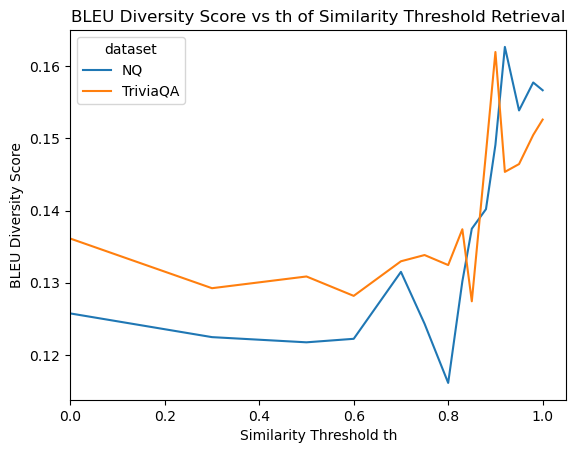

In [16]:
for project in ["threshold"]:
    term = vary_terms[project]
    name = project_names[project]
    for metric in ["Inter Diversity"]:
        score_data = pd.DataFrame(scores[project][metric])
        sns.lineplot(x=f'{term}', y=f'{metric} Score', data=score_data, hue="dataset")
        plt.xlabel("Similarity Threshold th")
        plt.ylabel("BLEU Diversity Score")
        plt.xlim(0,)
        plt.title(f'BLEU Diversity Score vs {term} of Similarity Threshold Retrieval')
        plt.savefig(f'bleu/{project}_{metric}.png')
        plt.show()
        

In [15]:
for ds in datasets:
    print("BLEU diversity of "+ds)
    print(score_data[score_data["dataset"]==ds])
    print('\n')

BLEU diversity of NQ
      th  Inter Diversity Score dataset
0   0.00               0.125742      NQ
1   0.30               0.122456      NQ
2   0.50               0.121736      NQ
3   0.60               0.122223      NQ
4   0.70               0.131504      NQ
5   0.75               0.124308      NQ
6   0.80               0.116108      NQ
7   0.83               0.130183      NQ
8   0.85               0.137480      NQ
9   0.88               0.140195      NQ
10  0.90               0.149117      NQ
11  0.92               0.162685      NQ
12  0.95               0.153881      NQ
13  0.98               0.157756      NQ
14  1.00               0.156679      NQ


BLEU diversity of TriviaQA
      th  Inter Diversity Score   dataset
15  0.00               0.136121  TriviaQA
16  0.30               0.129238  TriviaQA
17  0.50               0.130864  TriviaQA
18  0.60               0.128175  TriviaQA
19  0.70               0.132971  TriviaQA
20  0.75               0.133835  TriviaQA
21  0.80        